# Using Iguazio Frames Library for High-Performance Data Access 
iguazio `v3io_frames` is a streaming oriented multi-model (generic) data API which allow high-speed data loading and storing<br>
frames currently support iguazio key/value, time-series, and streaming data models (called backends), additional backends will be added

to use frames you first create a `client` and provide it the session and credential details, the client is used to to for 5 basic operations:
```
   create  - create a new key/value or time-series table or stream 
   delete  - delete the table or stream
   read    - read data from the backend (as pandas DataFrame or dataFrame iterator)
   write   - write one or more DataFrames into the backend
   execute - execute a command on the backend, each backend may support multiple commands 
```   

Content:
- [Working with key/value and SQL data](kv)
- [Working with Time-series data](#tsdb)
- [Working with Streams](#stream)

The following sections describe how to use frames, for more help and details use the internal documentation, e.g. run the following command
```  client.read?```


In [31]:
# fill the following environment var with real password
%env V3IO_PASSWORD = <V3IO Password>

env: V3IO_PASSWORD=<V3IO Password>


In [2]:
import pandas as pd
import v3io_frames as v3f
import os
client = v3f.Client('v3io-framesd:8081', password=os.getenv('V3IO_PASSWORD'))

<a id='kv'></a>
## Working with key/value and SQL data

### Load data from Amazon S3

In [3]:
# read S3 file into a data frame and show its data & metadata
tablename = 'bank'
df = pd.read_csv('https://s3.amazonaws.com/apache-zeppelin/tutorial/bank/bank.csv', sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


### Write data frames into the database using a single command
data is streamed into the database via fast NoSQL APIs, note the backend is `kv`<br>
the input data can be a single dataframe or a dataframe iterator (for streaming)

In [4]:
out = client.write('kv', tablename, df)

### Read from the Database with DB side SQL
offload data filtering, grouping, joins, etc to a scale-out high speed DB engine

In [5]:
%sql select * from bigdata.bank where balance > 10000

Done.


loan,education,previous,housing,poutcome,duration,marital,default,balance,month,contact,campaign,y,job,day,age,pdays
no,secondary,0,no,unknown,219,married,no,26452,jul,telephone,2,no,retired,15,75,-1
no,secondary,0,yes,unknown,249,married,no,19317,aug,cellular,1,yes,retired,4,68,-1


### Read the data through frames API
the frames API returns a dataframe or a dataframe iterator (a stream)<br>

In [6]:
df = client.read(backend='kv', table=tablename, filter="balance>20000")
df.head(8)

,default,day,contact,pdays,housing,y,age,month,previous,poutcome,marital,loan,duration,balance,job,education,campaign
__name,,,,,,,,,,,,,,,,,
75,no,15,telephone,-1,no,no,75,jul,0,unknown,married,no,219,26452,retired,secondary,2


### Read the data as a stream iterator
to use iterator and allow cuncurent data movement and processing add `iterator=True`, you will need to iterate over the returned value or use `concat`
iterators work with all backends (not just stream), they allow streaming when placed as an input to write functions which support iterators as input

In [11]:
dfs = client.read(backend='kv', table=tablename, filter="balance>20000", iterator=True)
for df in dfs:
    print(df.head())

        balance      job month   y housing  previous  age  campaign  duration  \
__name                                                                          
75        26452  retired   jul  no      no         0   75         2       219   

        day default  education    contact loan poutcome  marital  pdays  
__name                                                                   
75       15      no  secondary  telephone   no  unknown  married     -1  


### Batch updates with expression
in many cases we want to update specific column values or update a column using an expression (e.g. counter = counter + x)<br>
when using the key/value backend it can run an expression against each of the rows (specified in the index), and use the dataframe columns as parameters<br>
columns are specified using `{}`, e.g. specifing `expression="packets=packets+{pkt};bytes=bytes+{bytes};last_update={mytime}"` will add the data in `pkt` and `bytes` column from the input dataframe to the `packets` and `bytes` columns in the row and set the `last_update` field to `mytime`. the rows are selected based on the input dataframe index

In [ ]:
# example: creating a new column which reflect the delta between the old `loan` column and the one provided in df (should result in 0 since df didnt change)
out = client.write('kv', tablename, df, expression='loan_delta=loan-{loan}')

### Making a single row update using execute command
The use of `condition` is optional and allow to implement safe/conditional transactions 

In [ ]:
client.execute('kv',tablename,'update', args={'key':'1', 'expression': 'age=44', 'condition':'balance>0'})

### Delete the table
note: in kv (NoSQL) tabels there is no need to create a table before using it

In [12]:
client.delete('kv',table=tablename)

<a id='tsdb'></a>
## Working with time-series data

In [9]:
# create a time series table, rate specifies the typical ingestion rate (e.g. one sample per minute)
client.create(backend='tsdb', table='clustermon',attrs={'rate':'1/m'})

In [10]:
# create sample time-series data
import numpy as np
from datetime import datetime, timedelta
end = datetime.now().replace(minute=0, second=0, microsecond=0)
rng = pd.date_range(end=end, periods=60, freq='300s', tz='EST')
df = pd.DataFrame(np.random.randn(len(rng), 3), index=rng, columns=['cpu','mem','disk'])
df = df.cumsum()
print(df.info(), df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2018-12-19 10:05:00-05:00 to 2018-12-19 15:00:00-05:00
Freq: 300S
Data columns (total 3 columns):
cpu     60 non-null float64
mem     60 non-null float64
disk    60 non-null float64
dtypes: float64(3)
memory usage: 1.9 KB
None                                 cpu       mem      disk
2018-12-19 10:05:00-05:00 -0.577125 -0.222353 -0.059049
2018-12-19 10:10:00-05:00 -0.771442 -0.777262  0.397646
2018-12-19 10:15:00-05:00 -0.182062 -0.867828  0.382854
2018-12-19 10:20:00-05:00 -0.478918 -1.601443 -0.040379
2018-12-19 10:25:00-05:00 -0.080140 -2.427409 -0.642296


### Write to the time-series DB
The time series DB has a time based index and additional sub indexes called labels<br>
labels can be specified in two ways:
* Using the `labels` parameters which will add the specified labels to each row/sample<br>
* Using multi-index, all non time index columns are automatically converted to labels

if your DataFrame doesnt contain multi-index and you wish to use specific columns as time-series labels you should convert the columns to indexes using:<br>
```python
    df.index.name='time'                              # in case the index column is un-named 
    df.reset_index(level=0, inplace=True)    
    df = df.set_index(['time','symbol','exchange'])   # e.g. convert the specified columns to indexes 
```

Note: you can use both (multi-index and labels) together, the labels will be the aggregation of both 

In [11]:
client.write(backend='tsdb', table='clustermon',dfs=df, labels={'node':'11'})

### Read from the time-series DB


In [13]:
tsmetrics = client.read(backend='tsdb', table='clustermon', step='10m', aggragators='avg,max,count',start="now-5h", end='now')

In [14]:
pvt = tsmetrics.pivot_table('values',['Date','node'],['metric_name','Aggregate'])
pvt.head(15)

metric_name                    cpu                      disk                  \
Aggregate                      avg count       max       avg count       max   
Date                node                                                       
2018-12-19 14:57:22 11   -0.577125   1.0 -0.577125 -0.059049   1.0 -0.059049   
2018-12-19 15:07:22 11   -0.476752   2.0 -0.182062  0.390250   2.0  0.397646   
2018-12-19 15:17:22 11   -0.279529   2.0 -0.080140 -0.341337   2.0 -0.040379   
2018-12-19 15:27:22 11   -0.159337   2.0  0.625181 -0.767914   2.0 -0.245801   
2018-12-19 15:37:22 11   -2.554173   2.0 -1.524192 -2.992264   2.0 -2.894977   

metric_name                    mem                  
Aggregate                      avg count       max  
Date                node                            
2018-12-19 14:57:22 11   -0.222353   1.0 -0.222353  
2018-12-19 15:07:22 11   -0.822545   2.0 -0.777262  
2018-12-19 15:17:22 11   -2.014426   2.0 -1.601443  
2018-12-19 15:27:22 11   -2.376977   2.0 -1.294460  
2018-12-19 15:37:22 11   -4.383982   2.0 -3.993700

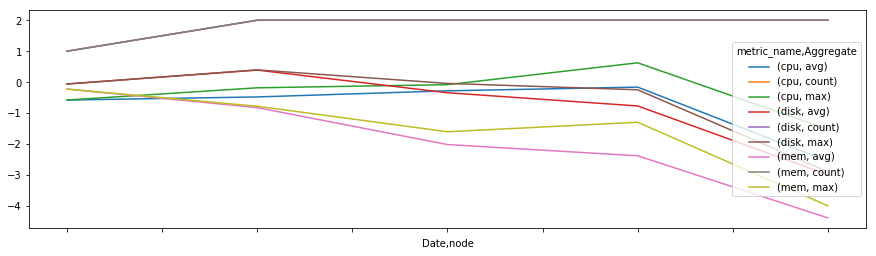

In [17]:
%matplotlib inline
pvt.plot(figsize=[15,4])

### Delete the table

In [18]:
client.delete('tsdb','clustermon')

<a id='stream'></a>
## Working with streams
iguazio platform support streams which have AWS Kinesis like API, they can be accessed from the notebook as if they were a structured stream (currently assume the structure is serialized through `JSON`. streams can be accessed in a bulk, or preferably using an iterator.<br>
Streams must be first created, users can specify the number of shards and retention period when creating the stream.

In [19]:
client.create(backend='stream', table='somestream',attrs={'retention_hours':48,'shards':1})

In [21]:
# write data into a stream
def gendf():
    end = datetime.now().replace(minute=0, second=0, microsecond=0)
    rng = pd.date_range(end=end, periods=60, freq='300s', tz='Israel')
    df = pd.DataFrame(np.random.randn(len(rng), 3), index=rng, columns=['cpu', 'mem', 'disk'])
    return df

client.write('stream', 'somestream', gendf())

### Reading from a stream
the stream read operation need to specify the seek method and parameters (each seek method may have different parameters) as listed below:
```
   earliest   - start from the earliest point in the stream (no params)
   latest     - start from the latest, i.e. show only new records
   time       - start from a point in time, specify the start param e.g. start='now-1d'
   sequence   - start from a specific sequence number, specify the sequence param e.g. sequence=45
```



In [29]:
dfs = client.read('stream', 'somestream',seek='earliest', shard_id='0', iterator=True)
for df in dfs:
    print(df.head(4))

                disk               index-0       mem  \
seq_number                                             
1           1.491374  2018-12-19T09:05:00Z -0.226499   
2           0.606867  2018-12-19T09:10:00Z  1.363093   
3          -0.015122  2018-12-19T09:15:00Z -1.437457   
4           1.621618  2018-12-19T09:20:00Z -0.500397   

                             stream_time       cpu  
seq_number                                          
1          2018-12-19 16:12:54.494939735  1.711060  
2          2018-12-19 16:12:54.494939735 -1.269873  
3          2018-12-19 16:12:54.494939735  0.241201  
4          2018-12-19 16:12:54.494939735 -1.027548  


### Push a single record update to a stream
In some cases it is more conviniant to just push a buffer into a stream, for that use the execute `put` command <br>
put accepts the `data` arg and two optional parameters (`clientinfo` for some extra info and `partition` if you want to specify the shard id)

In [ ]:
client.execute('stream', 'somestream', 'put', args={'data': 'abcd', 'clientinfo': '123'})

### Delete the stream

In [30]:
client.delete('stream','somestream')